In [2]:
import numpy as np
import simtk.openmm as mm
import simtk.openmm.app as app
from simtk.openmm import unit
from simtk.openmm.openmm import NonbondedForce
import os
import matplotlib.pyplot as plt
from openmmtools.testsystems import AlanineDipeptideExplicit
import sys
import matplotlib.ticker as ticker

In [3]:
def percentageString(progress, total, divisions):
    length=total/divisions
    stage=int(progress//length)
    token=">"
    if progress==total:
        token="X"
    return "["+"="*stage+token+" "*(divisions-stage)+"]"

In [4]:
name="alad-015M-15A"
run="NOCHARMM-noUS"#no umbrella sampling 
fetchrun="NOCHARMM-NPT"
fetchdir=f"results/alad-015M-15A-run-{fetchrun}/"
resultsdir="results/"+"{}-run-{}".format(name,run)
if not os.path.exists(resultsdir):
    os.mkdir(resultsdir)
    print("done")

done


In [5]:
a,b,c = np.loadtxt("{}".format(fetchdir)+'NPT-box-lengths_{}.txt'.format(name))

In [6]:
pdb = app.PDBFile(fetchdir+"equilibrated-NPT_{}.pdb".format(name))

In [7]:
#System Parameters
constraints = app.HBonds
nonbonded_cutoff = 1.0*unit.nanometer
switch_distance = 0.8*unit.nanometer
nonbonded_method = app.PME
implicit_solvent = False
solvated = True
hydrogen_mass = None

In [8]:
#Simulation parameters
friction = 1.0 / unit.picoseconds
pressure = 1.0 * unit.atmosphere
temperature = 298*unit.kelvin
timestep = 2.0 * unit.femtosecond

In [9]:
create_system_kwargs = dict(
    removeCMMotion=True,
    nonbondedMethod=nonbonded_method,
    nonbondedCutoff=nonbonded_cutoff,
    switchDistance=switch_distance,
    constraints=constraints,
    hydrogenMass=hydrogen_mass,
    rigidWater=True,
)

In [10]:
alanine=AlanineDipeptideExplicit(**create_system_kwargs)

In [21]:
alanine.system.setDefaultPeriodicBoxVectors(
    mm.Vec3(a,0,0),
    mm.Vec3(0,b,0),
    mm.Vec3(0,0,c)
)

In [22]:
#Set up simulation
system = alanine.system

positions = pdb.getPositions()
topology = alanine.topology

integrator = mm.LangevinIntegrator(temperature , friction , timestep)
integrator.setConstraintTolerance(1e-7)

platform = mm.Platform.getPlatformByName("OpenCL")
platform_properties = {"DeviceIndex": "0", "Precision": "mixed"}

In [23]:
simulation = mm.app.Simulation(topology, system, integrator, platform, platform_properties)
simulation.context.setPositions(positions)
simulation.context.setVelocitiesToTemperature(temperature)

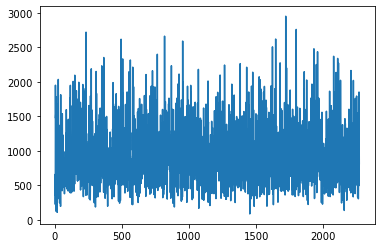

In [24]:
#Check for any unusal forces
orces=simulation.context.getState(getForces=True).getForces(asNumpy=True)
forces_total=np.sqrt(forces[:,0]**2+forces[:,1]**2+forces[:,2]**2)
n=np.arange(len(forces_total))
plt.plot(n,forces_total)

In [25]:
## To run in NPT ensemble
# barostat = mm.MonteCarloBarostat(pressure, temperature)
# force_id = simulation.context.getSystem().addForce(barostat)


simulation.minimizeEnergy()
simulation.reporters.append(app.DCDReporter('{}/{}-run-{}.dcd'.format(resultsdir, name, run), 5000))
simulation.reporters.append(app.StateDataReporter('{}/{}-scalars-{}.csv'.format(resultsdir, name, run), 
    1000, time=True, potentialEnergy=True, totalEnergy=True,
    temperature=True, speed=True, elapsedTime=True))

In [26]:
# How frequently to save
step_size = 100
# How many steps that are saved
n_steps = 50
# How many times to save
loops = 1000
atom_list = []
for residue in topology.residues():
    if residue.name != 'HOH':
        print(residue.name)
        for atom in residue.atoms():
            atom_list.append(atom.index)

ACE
ALA
NME


In [27]:
print(f"Simulation time: {timestep.in_units_of(unit.nanosecond)*step_size*n_steps*loops}")

Simulation time: 10.000000000000002 ns


In [28]:
last_chk=0

In [29]:
for loop in range(last_chk,loops):
    forces_list = []
    position_list = []
    energies = []
    for ix in range(n_steps):
        forces_list.append([])
        position_list.append([])
        forces = simulation.context.getState(getForces=True).getForces(asNumpy=True)[atom_list]
        forces = forces.value_in_unit(unit.kilocalorie_per_mole/unit.angstrom)
        position = simulation.context.getState(getPositions=True,enforcePeriodicBox=True).getPositions(asNumpy=True)[atom_list]
        position = position.value_in_unit(unit.angstrom)
        energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
        energy = energy.value_in_unit(unit.kilocalorie_per_mole)

        forces_list[-1].append(forces)
        position_list[-1].append(position)
        energies.append(energy)
        simulation.step(step_size)
        percentageBar=percentageString((ix+(loop*n_steps)),(n_steps*loops-1),50)
        print("\rSimulating: {:.06f}%  {}".format((ix+(loop*n_steps))/(n_steps*loops)*100,percentageBar), end="")

    with open('{}/{}-{}-checkpoint.chk'.format(resultsdir,name, loop), 'wb') as f:
        f.write(simulation.context.createCheckpoint())

    forces = np.concatenate(forces_list,axis=0)
    positions = np.concatenate(position_list,axis=0)
    np.save('{}/{}-{}-forces.npy'.format(resultsdir,name, loop),forces)
    np.save('{}/{}-{}-coords.npy'.format(resultsdir,name, loop),positions)
    np.save('{}/{}-{}-energy.npy'.format(resultsdir,name, loop),energies)



Simulating: 99.998000%  [=================================================X ]

In [30]:
#Saving the files
crd = simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions()
pdb.writeFile(topology, crd, open(resultsdir+'/{}-run-{}.pdb'.format(name,run), 'w'))


In [13]:
#Load checkpoints in case of premature program termination
with open('{}/{}-{}-checkpoint.chk'.format(resultsdir,name, last_chk), 'rb') as f:
        simulation.context.loadCheckpoint(f.read())